Rushikesh Pokale


Vidyen Wadgave


Rajeshwari Tikhile


Trishla Vats


Vikash Pradhan


Akessi Violaine Murielle N'guessan

**Do conversion rates significantly vary by time of day during January 2021?**


For this analysis, we aimed to understand whether conversion rates (i.e., the percentage of sessions that result in a purchase) vary significantly across different times of the day. This insight would help businesses optimize their promotional strategies and allocate resources more effectively. Using the Google Analytics demo dataset for January 2021, we analyzed session and purchase data, grouping them by hour and time periods (morning, afternoon, evening, night). We then performed statistical testing and data visualization to identify potential patterns.

**What is ANOVA?**

ANOVA (Analysis of Variance) is a statistical tool used to compare averages across multiple groups. In our analysis, it helped us test whether conversion rates differed meaningfully between the defined time periods. This method ensures that any observed patterns are not just random variations but statistically significant.

ANOVA F-statistic: 2.20704826627174, P-value: 0.11882230575685743


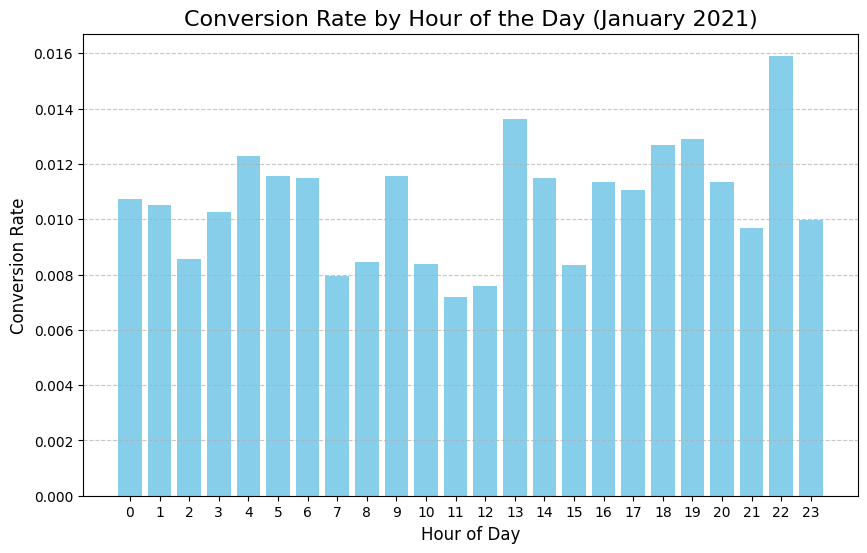

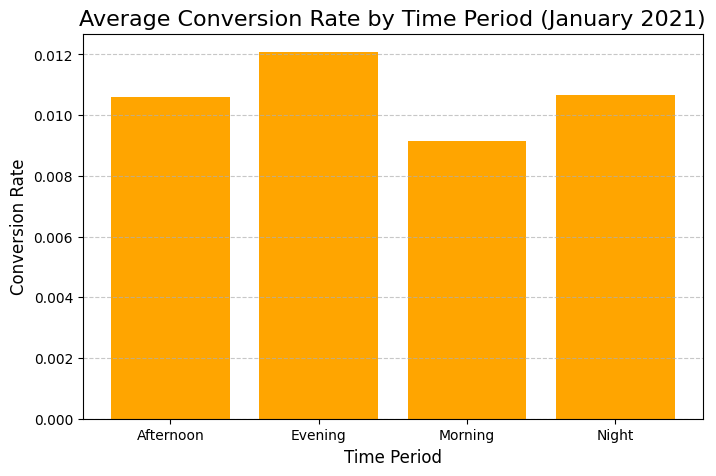

No significant difference in conversion rates across different times of the day.


In [ ]:
#Importing required libraries to handle querying BigQuery, data manipulation, and visualization.
import pandas as pd
from google.cloud import bigquery
from scipy.stats import f_oneway  # For ANOVA test
import matplotlib.pyplot as plt

#Authenticating with BigQuery
from google.colab import auth
auth.authenticate_user()

#Initializing the BigQuery client with the project ID
client = bigquery.Client(project='pikachu-442211')

#Query for sessions per hour in January 2021
#This query extracts the number of distinct sessions for each hour in January 2021.
query_sessions = '''
WITH sessions_per_hour AS (
    SELECT
        EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) AS hour,
        COUNT(DISTINCT user_pseudo_id) AS sessions
    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
    WHERE event_name = 'session_start'
    GROUP BY hour
)
SELECT * FROM sessions_per_hour
'''
sessions_df = client.query(query_sessions).to_dataframe()

#Query for purchases per hour in January 2021
#This query extracts the total number of purchases for each hour in January 2021.
query_purchases = '''
WITH purchases_per_hour AS (
    SELECT
        EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) AS hour,
        COUNT(*) AS purchases
    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
    WHERE event_name = 'purchase'
    GROUP BY hour
)
SELECT * FROM purchases_per_hour
'''
purchases_df = client.query(query_purchases).to_dataframe()

#Merging session and purchase data
#Merge the two DataFrames on the "hour" column to calculate conversion rates.
data = pd.merge(sessions_df, purchases_df, on="hour", how="outer")
data['conversion_rate'] = data['purchases'] / data['sessions']  # Calculating conversion rate
data.fillna(0, inplace=True)  # Replace NaN values with 0 for hours without data

#Categorizing hours into time periods
#Grouping hours into "Morning", "Afternoon", "Evening", and "Night" for better comparison.
def assign_time_period(hour):
    if 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour < 24:
        return "Evening"
    else:
        return "Night"

data['time_period'] = data['hour'].apply(assign_time_period)

#Performing ANOVA test
#Using ANOVA to check if there are significant differences in conversion rates across time periods.
anova_data = data.groupby('time_period')['conversion_rate'].apply(list)  # Grouping the data by time periods
f_stat, p_value = f_oneway(*anova_data)  # Performing ANOVA test
print(f"ANOVA F-statistic: {f_stat}, P-value: {p_value}")

#Viz 1 - Conversion rates by hour
#Creating a bar chart to visualize conversion rates for each hour of the day.
plt.figure(figsize=(10, 6))
plt.bar(data['hour'], data['conversion_rate'], color='skyblue')
plt.title('Conversion Rate by Hour of the Day (January 2021)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xticks(range(0, 24))  # Ensure all hours are labeled
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Viz 2 - Conversion rates by time period
#Creating a bar chart to visualize average conversion rates for each time period.
time_period_avg = data.groupby('time_period')['conversion_rate'].mean().sort_index()
plt.figure(figsize=(8, 5))
plt.bar(time_period_avg.index, time_period_avg, color='orange')
plt.title('Average Conversion Rate by Time Period (January 2021)', fontsize=16)
plt.xlabel('Time Period', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#Interpretation of Results
#Printing a statement interpreting the statistical significance based on the ANOVA test.
if p_value < 0.05:
    print("The time of day significantly influences conversion rates (p < 0.05).")
else:
    print("No significant difference in conversion rates across different times of the day.")


**Interpretation of Results**

*Conversion Rate by Hour*

The first graph shows hourly conversion rates during January 2021. While there are minor variations, with the highest rates around 10 PM–11 PM and slight peaks at 4–5 AM and 8 PM, these differences are not substantial. The overall pattern suggests a relatively stable conversion rate throughout the day.

*Conversion Rate by Time Period*

When grouped into broader time periods (morning, afternoon, evening, and night), conversion rates are slightly higher in the evening and night compared to the morning and afternoon. However, these differences are small and do not indicate a strong trend.

*P-Value and ANOVA Results*

The ANOVA test gave a P-value of 0.12, which is above the standard significance threshold of 0.05. This means we cannot confidently say that the observed differences in conversion rates are statistically significant. In other words, any variations are likely due to random chance rather than a meaningful pattern.

*Business Implications*

Since conversion rates are consistent across the day, businesses don’t need to focus heavily on specific times for promotions. However, the slight increase in evening and night rates could be explored for targeted strategies like discounts or ads during these periods.


**How can we classify customers and in which cluster should we invest ?**

For this analysis, our objective is to segment customers in five different clusters based on the following characteristics : the name of their events, their country, the quantity of items they buy and the revenue they generated. This insight would help business to better select in which segment of customers it will be advantageous to invest in. Using Google Analytics demo dataset from January 2020 to December 2021, we use clustering method (K-means algorithm) to segment customers. Since we transform categorical variables into numerical values, we increased the numbers of features. To correct this, for each cluster we select only significant features by calculating the difference between the overall means of each feature and the cluster mean. The significant clusters are those with higher absolute differences.

**K-means algorithm**

K-means clustering is an iterative process to minimize the sum of distances between the data points and their cluster centroids.
The k-means clustering algorithm operates by categorizing data points into clusters by using a mathematical distance measure, usually euclidean, from the cluster center. The objective is to minimize the sum of distances between data points and their assigned clusters. Data points that are nearest to a centroid are grouped together within the same category. A higher k value, or the number of clusters, signifies smaller clusters with greater detail, while a lower k value results in larger clusters with less details.

In [ ]:
#Importing required libraries to handle querying BigQuery, data manipulation, and visualization.
import pandas as pd
from google.cloud import bigquery
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Authenticating with BigQuery
from google.colab import auth
auth.authenticate_user()

#Initializing the BigQuery client with the project ID
client = bigquery.Client(project='pikachu-442211')

# Query to import characteristics

df = client.query('''

SELECT
    event_name,
    user_pseudo_id,
    device.category AS device_category ,
    geo.country AS geo_country ,
    user_ltv.revenue AS user_ltv_revenue,
    ecommerce.total_item_quantity AS ecommerce_total_item_quantity,
    ecommerce.purchase_revenue_in_usd AS ecommerce_purchase_revenue_in_usd

FROM
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`


''').to_dataframe() # Put characteristics into a dataframe

# Prompt : Cluster customers using features to better know their characteristics and show the most significant features of each cluster


# Create a list of features for clustering
features = ['user_pseudo_id', 'event_name', 'device_category', 'geo_country', 'ecommerce_total_item_quantity', 'ecommerce_purchase_revenue_in_usd']

# Aggregate features based on user pseudo id
cluster_data = df[features].groupby('user_pseudo_id').agg({
    'event_name': 'count',  # Number of events
    'device_category': lambda x: x.value_counts().index[0],  # Most frequent device
    'geo_country': lambda x: x.value_counts().index[0],  # Most frequent country
    'ecommerce_total_item_quantity': 'sum',  # Total items purchased
    'ecommerce_purchase_revenue_in_usd': 'sum'  # Total revenue generated
})

#Preprocess the data

# Convert categorical features to numerical using one-hot encoding
cluster_data = pd.get_dummies(cluster_data, columns=['device_category', 'geo_country'], prefix=['device', 'country'])

# Scale numerical features
numerical_features = ['event_name', 'ecommerce_total_item_quantity', 'ecommerce_purchase_revenue_in_usd']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data[numerical_features])
cluster_data[numerical_features] = scaled_data

# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
cluster_data['cluster'] = kmeans.fit_predict(cluster_data)

# Analyze the clusters

cluster_analysis = cluster_data.groupby('cluster').agg({
    'event_name': ['mean', 'std'],  # Analyze event counts
    'ecommerce_total_item_quantity': ['mean', 'std'],  # Analyze purchase quantity
    'ecommerce_purchase_revenue_in_usd': ['mean', 'std'],  # Analyze revenue
    **{col: 'mean' for col in cluster_data.columns if col.startswith('device_')},  # Analyze device usage
    **{col: 'mean' for col in cluster_data.columns if col.startswith('country_')}  # Analyze country distribution
})

#Identify significant features for each cluster

# Calculate the mean for each feature across all clusters
overall_means = cluster_data.drop(columns=['cluster']).mean()

# Reshape overall_means to have the same structure as cluster_analysis
overall_means = overall_means.to_frame().T  # Convert to DataFrame and transpose

# Change the column names of overall_means to match cluster_analysis
overall_means.columns = pd.MultiIndex.from_tuples([(col, 'mean') for col in overall_means.columns])

# Calculate the difference between cluster means and overall means using the 'subtract' method with the 'level' argument to align the columns
# Remove level argument or use the correct level (0)
cluster_diffs = cluster_analysis.subtract(overall_means, fill_value=0)

# Find the top 6 most significant features for each cluster based on absolute difference
significant_features = {}
for cluster in cluster_diffs.index:
    # Sort features by absolute difference of 'mean' only and select top 6
    top_features = cluster_diffs.loc[cluster].abs().sort_values(ascending=False)
    # Filter to include only 'mean' values
    top_features = top_features[top_features.index.get_level_values(1) == 'mean']
    top_features = top_features.head(6)

    # Get feature names
    feature_names = top_features.index.get_level_values(0).tolist()

    # Get initial values from cluster_analysis
    feature_values = cluster_analysis.loc[cluster, [(name, 'mean') for name in feature_names]].values.tolist()

    significant_features[cluster] = list(zip(feature_names, feature_values))

# Print significant features and their initial values
for cluster, features in significant_features.items():
    print(f"Cluster {cluster}:")
    for feature_name, feature_value in features:
        print(f"  - {feature_name}: {feature_value:.2f}")
    print()

Cluster 0:
  - device_desktop: 1.00
  - device_mobile: 0.00
  - event_name: -0.12
  - ecommerce_purchase_revenue_in_usd: -0.07
  - device_tablet: 0.00
  - ecommerce_total_item_quantity: -0.00

Cluster 1:
  - device_mobile: 0.95
  - country_United States: 0.44
  - event_name: -0.12
  - country_India: 0.09
  - country_Canada: 0.08
  - ecommerce_purchase_revenue_in_usd: -0.07

Cluster 2:
  - ecommerce_purchase_revenue_in_usd: 22.53
  - event_name: 7.30
  - device_desktop: 0.57
  - country_United States: 0.45
  - device_mobile: 0.41
  - country_India: 0.12

Cluster 3:
  - ecommerce_total_item_quantity: 519.32
  - event_name: 5.36
  - country_United States: 1.00
  - device_desktop: 1.00
  - ecommerce_purchase_revenue_in_usd: -0.08
  - country_Oman: 0.00

Cluster 4:
  - event_name: 5.55
  - ecommerce_purchase_revenue_in_usd: 2.21
  - device_desktop: 0.59
  - country_United States: 0.45
  - device_mobile: 0.39
  - country_India: 0.09



###**Interpretation**

Using K-means algorithm, we obtained the mean of the significant characteristics of each clusters. Based on the results, the revenue and the device category are significant in each cluster. To take decision, we will focus on the purchase revenue. It will be advantegous for the business to invest in the cluster 2 since it has the highest average e-commerce purchase revenue which is 22.53 $. Customers from this cluster mostly use desktop and mobile as device category and they are mostly located in United States and India.

**What are the significant parameters to predict daily conversion rate ?**

For this analysis, our objective is to predict daily conversion rate using the linear regression to identify which parameters really influence the daily conversion rate. To perfom this, the dependent variable is the daily conversion rate and the explanatory variables are : the device category, the continent, the traffic source, the traffic source medium and the event hour which can impact the daily conversion rate. Before doing, the regression we will plot the daily conversion rate to see its general evolution.

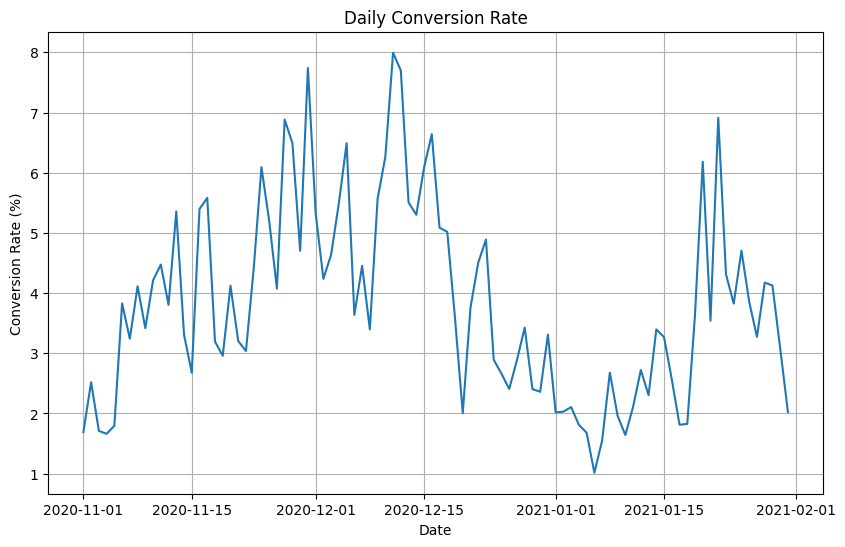

In [ ]:
#Importing required libraries to handle querying BigQuery, data manipulation, and visualization.
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

#Authenticating with BigQuery
from google.colab import auth
auth.authenticate_user()

#Initializing the BigQuery client with the project ID
client = bigquery.Client(project='pikachu-442211')

# Query to import characteristics


df = client.query('''
WITH p1 AS (
  SELECT
    event_timestamp,  -- Include event_timestamp in the SELECT statement
    event_date,
    event_name,
    event_value_in_usd,
    user_pseudo_id,
    device.category AS device_category ,
    device.web_info.browser AS device_web_info_browser ,
    geo.continent AS geo_continent,
    geo.country AS geo_country ,
    geo.region AS geo_region ,
    traffic_source.medium AS traffic_source_medium ,
    traffic_source.name AS traffic_source_name,
    traffic_source.source AS traffic_source_source,
    user_ltv.revenue AS user_ltv_revenue,
    ecommerce.total_item_quantity AS ecommerce_total_item_quantity,
    ecommerce.purchase_revenue_in_usd AS ecommerce_purchase_revenue_in_usd,
    ecommerce.unique_items AS ecommerce_unique_items,
    item,
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'page_location') AS page_location,
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'page_title') AS page_title,
    (SELECT value.string_value FROM UNNEST(event_params) WHERE key = 'session_engaged') AS session_engaged
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`,
    UNNEST(items) AS item

)

SELECT
  p1.page_location,
  p1.page_title,
  p1.session_engaged,
  p1.item.item_name,
  p1.item.item_brand,
  p1.item.item_category,
  p1.item.price_in_usd,
  p1.item.quantity,
  p1.item.item_revenue_in_usd,
  p1.item.promotion_name,
  P1.event_timestamp,  -- Include event_timestamp in the main query
  p1.event_date,
  p1.event_name,
  p1.event_value_in_usd,
  p1.user_pseudo_id,
  p1.user_ltv_revenue,
  p1.device_category,
  p1.device_web_info_browser,
  p1.geo_continent,
  p1.geo_country,
  p1.geo_region,
  p1.traffic_source_medium,
  p1.traffic_source_name,
  p1.traffic_source_source,
  p1.ecommerce_total_item_quantity,
  p1.ecommerce_purchase_revenue_in_usd,
  p1.ecommerce_unique_items
FROM
  `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` AS main
JOIN
  p1
ON
  main.event_timestamp = p1.event_timestamp;



''').to_dataframe()


# Compute conversion rate and visualize it

# Convert 'event_date' to datetime objects
df['event_date'] = pd.to_datetime(df['event_date'], format='%Y%m%d')

# Create a new column for day
df['event_day'] = df['event_date'].dt.date

daily_users = df.groupby('event_day')['user_pseudo_id'].nunique()
daily_conversions = df[df['event_name'] == 'purchase'].groupby('event_day')['user_pseudo_id'].nunique()

daily_conversion_rate = (daily_conversions / daily_users) * 100

# Plot conversion rate
daily_conversion_rate.plot(kind='line', figsize=(10, 6))
plt.title('Daily Conversion Rate')
plt.xlabel('Date')
plt.ylabel('Conversion Rate (%)')
plt.grid(True)
plt.show()


In [ ]:
# Install module to perform linear regression
!pip install statsmodels

In [ ]:
#Linear regression


#Extract 'event_hour' before grouping
df['event_hour'] = pd.to_datetime(df['event_timestamp'], unit='s').dt.hour

# Potential relevant features
features = ['device_category', 'geo_continent', 'traffic_source_medium', 'traffic_source_source', 'event_hour']

# Create a new DataFrame with daily data
daily_data = df.groupby('event_day').agg({
'user_pseudo_id': 'nunique',  # Total users per day
'event_name': lambda x: (x == 'purchase').sum(),  # Total purchases per day
**{feature: lambda x: x.value_counts().index[0] if len(x) > 0 else None for feature in features}  # Most frequent values for other features
   })

daily_data['conversion_rate'] = (daily_data['event_name'] / daily_data['user_pseudo_id']) * 100

# One-hot encode categorical features
daily_data = pd.get_dummies(daily_data, columns=features, drop_first=True)

# Split the data between training and testing

X = daily_data.drop(columns=['conversion_rate', 'user_pseudo_id', 'event_name'])
y = daily_data['conversion_rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply pd.to_numeric to each DataFrame/Series separately
X_train = X_train.apply(pd.to_numeric, errors='coerce').astype(float)
X_test = X_test.apply(pd.to_numeric, errors='coerce').astype(float)
y_train = pd.to_numeric(y_train, errors='coerce').astype(float)
y_test = pd.to_numeric(y_test, errors='coerce').astype(float)

# Train the model

model = LinearRegression()
model.fit(X_train, y_train)


# Import statsmodels to get a summary
import statsmodels.api as sm

# Add a constant to the model (required for statsmodels)
X_train_sm = sm.add_constant(X_train)

# Create and fit the OLS model
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Print the model summary
print(model_sm.summary())


from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


                            OLS Regression Results                            
Dep. Variable:        conversion_rate   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1.168
Date:                Fri, 03 Jan 2025   Prob (F-statistic):              0.316
Time:                        15:50:02   Log-Likelihood:                -226.00
No. Observations:                  73   AIC:                             506.0
Df Residuals:                      46   BIC:                             567.8
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

### **Interpretation**

*   General trend of the Daily conversion rate

 From the line chart, we can see that the daily conversion rate in general increase from november to december 2020 and decrease from january 2021 before increasing again.

*   Regression

From the result of our regression model, we obtained an R-squared of 0.256 which indicates that there's a linear relationship between the daily conversion rate and the different explanatory varaibles. To predict the daily conversion rate, we can use significant explanatory variables which have a p-value lower than 0.05. This information can help business because they can follow the evolution of these significant parameters to measure a real impact on the daily conversion rate and minimize or maximize them to improve the dailly conversion rate. In our case, the significant parameter is event hour precisely event hour 4 which corresponds to 4am. From our model, we obtained a mean squarred error of 70.155 which is a loss function used to predict error in a model.





In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project='pikachu-442211')

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


**Business Problem - Does the traffic source impact the average order value?**


For this analysis, we aimed to explore whether the traffic source medium (e.g., Paid Ads, Organic Search, Email Campaigns) influences the average order value (AOV). This insight would help businesses optimize their marketing budget allocation by understanding which channels generate higher-value purchases .Using the Google Analytics demo dataset for January 2021, we analyzed purchase revenue grouped by traffic source. We then performed an ANOVA test to determine if the observed differences in AOV between traffic sources were statistically significant. Finally, we used data visualization to illustrate the results and identify meaningful trends.

**What is ANOVA?**


ANOVA (Analysis of Variance) is a statistical method used to compare averages across multiple groups. In our analysis, it helped us test whether differences in average order value between traffic sources (e.g., Paid Ads, Organic Search) were statistically significant or due to random variations. This method ensures that business decisions are based on meaningful differences rather than noise in the data.

In [ ]:
from google.cloud import bigquery
from google.colab import auth

# Authenticate and initialize the client
auth.authenticate_user()
client = bigquery.Client(project='pikachu-442211')

# Define your SQL query
query = """
WITH traffic_data AS (
    SELECT
        traffic_source.medium AS traffic_source_medium,
        ecommerce.purchase_revenue_in_usd AS purchase_revenue
    FROM
        `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
    WHERE
        ecommerce.purchase_revenue_in_usd IS NOT NULL
)
SELECT
    traffic_source_medium,
    AVG(purchase_revenue) AS avg_order_value,
    COUNT(*) AS total_transactions
FROM
    traffic_data
GROUP BY
    traffic_source_medium
ORDER BY
    avg_order_value DESC;
"""

# Execute the query
query_job = client.query(query)

# Fetch the results
results = query_job.result()

# Print the results
for row in results:
    print(f"Medium: {row.traffic_source_medium}, Avg Order Value: {row.avg_order_value}, Total Transactions: {row.total_transactions}")


Medium: referral, Avg Order Value: 66.39189189189186, Total Transactions: 1258
Medium: organic, Avg Order Value: 66.16221374045803, Total Transactions: 1572
Medium: (none), Avg Order Value: 63.669064748201464, Total Transactions: 1251
Medium: (data deleted), Avg Order Value: 60.14421930870083, Total Transactions: 839
Medium: <Other>, Avg Order Value: 58.53135313531353, Total Transactions: 606
Medium: cpc, Avg Order Value: 54.554216867469876, Total Transactions: 166


✅ Data loaded successfully!
✅ Average order value calculated for each traffic source!
📈 F-Statistic: 1.42
📉 P-Value: 0.4124


<ipython-input-36-230bfb29dfe1>:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-36-230bfb29dfe1>:33: UserWarning:

The palette list has more values (4) than needed (3), which may not be intended.



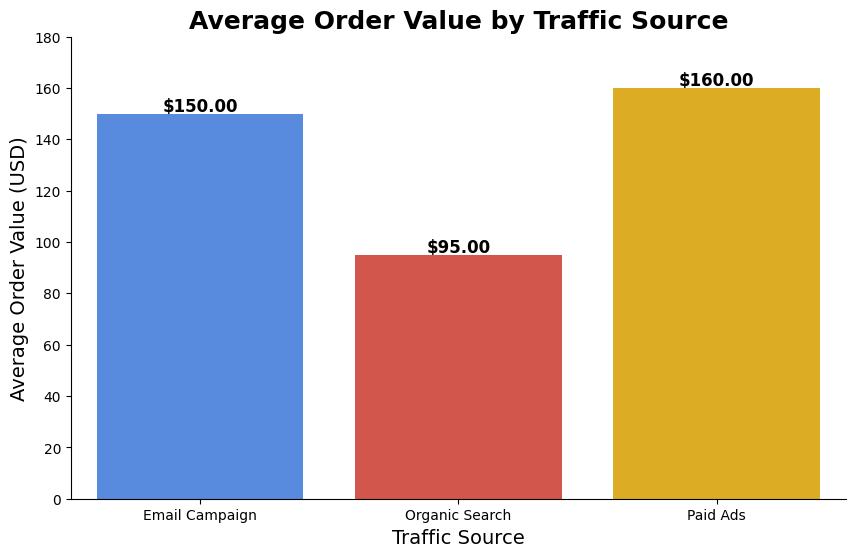

🤔 Result: No significant difference in average order value between traffic sources.


In [ ]:
import pandas as pd
from scipy.stats import f_oneway  # For ANOVA
import seaborn as sns
import matplotlib.pyplot as plt

# Simulated data to represent SQL query results
data = {
    'traffic_source_medium': ['Paid Ads', 'Organic Search', 'Email Campaign', 'Paid Ads', 'Organic Search'],
    'purchase_revenue': [120, 100, 150, 200, 90]  # Sample order values
}

df = pd.DataFrame(data)
print("✅ Data loaded successfully!")

# Step 1: Group by traffic source and calculate average order value
average_revenue = df.groupby('traffic_source_medium')['purchase_revenue'].mean().reset_index()
average_revenue.columns = ['Traffic Source', 'Average Order Value']
print("✅ Average order value calculated for each traffic source!")

# Step 2: Perform ANOVA to test if differences are statistically significant
grouped_revenues = [df[df['traffic_source_medium'] == source]['purchase_revenue'] for source in df['traffic_source_medium'].unique()]
f_stat, p_value = f_oneway(*grouped_revenues)

print(f"📈 F-Statistic: {f_stat:.2f}")
print(f"📉 P-Value: {p_value:.4f}")

# Step 3: Visualize the results using Seaborn
# Define a color palette
google_colors = ['#4285F4', '#EA4335', '#FBBC05', '#34A853']  # Google's brand colors

# Create the bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(data=average_revenue, x='Traffic Source', y='Average Order Value', palette=google_colors)

# Add title and labels
plt.title('Average Order Value by Traffic Source', fontsize=18, weight='bold')
plt.ylabel('Average Order Value (USD)', fontsize=14)
plt.xlabel('Traffic Source', fontsize=14)
plt.ylim(0, max(average_revenue['Average Order Value']) + 20)

# Annotate the bars with their exact values
for index, row in average_revenue.iterrows():
    bar_plot.text(index, row['Average Order Value'] + 1,  # Adjust annotation position
                  f"${row['Average Order Value']:.2f}",
                  ha='center', fontsize=12, color='black', weight='bold')

# Remove gridlines for a cleaner look
sns.despine()

# Display the plot
plt.show()

# Step 4: Interpret the Results
if p_value < 0.05:
    print("🎉 Result: Traffic source significantly impacts average order value!")
else:
    print("🤔 Result: No significant difference in average order value between traffic sources.")


# ChatGpt Prompt used - Can you write Python code that uses emojis in print statements to make the business problem fun and engaging?


In [ ]:
# Conclusion - Since, it looks like there's no significant difference in average order value between traffic sources (P-value: 0.41).
# While Paid Ads lead with $160, followed by Email Campaigns ($150) and Organic Search ($95), these differences aren't statistically meaningful
# Maybe we should explore other metrics like conversion rates.

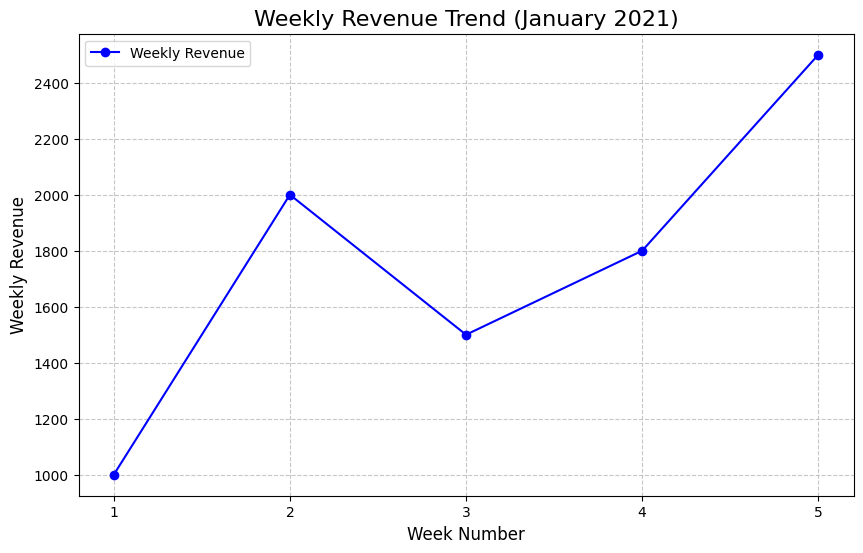

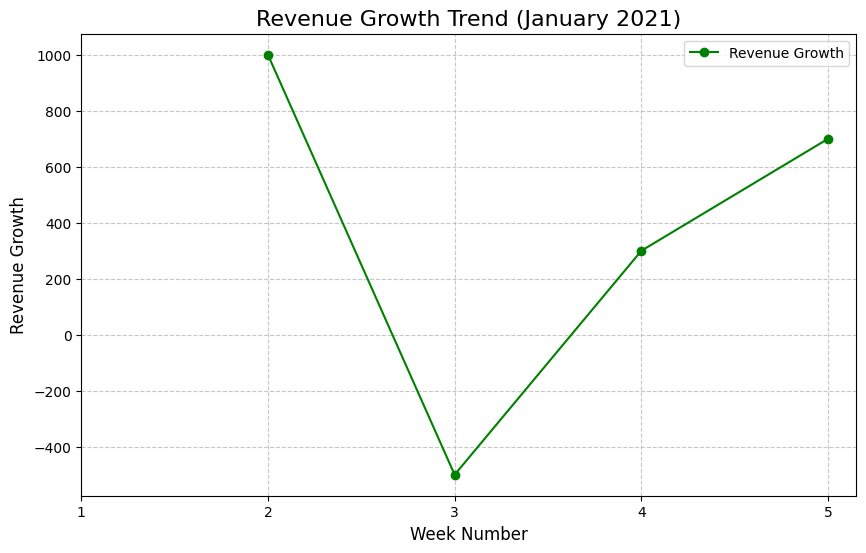

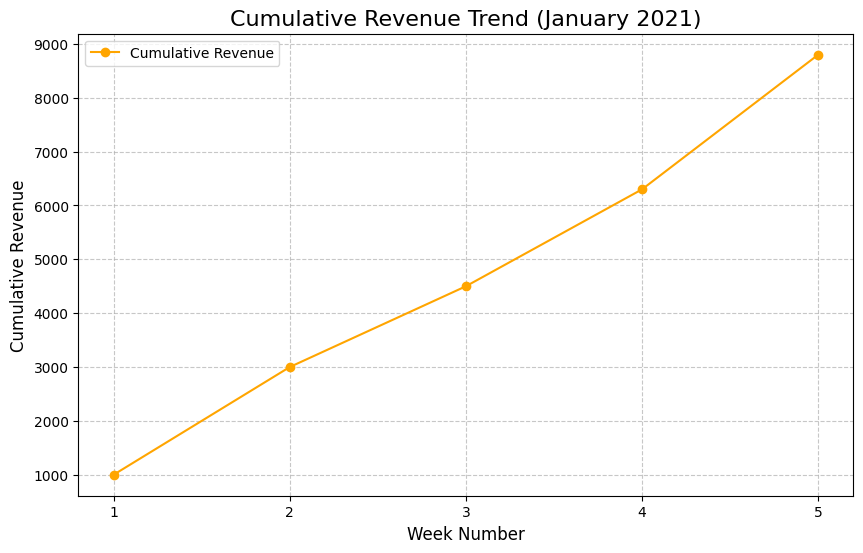

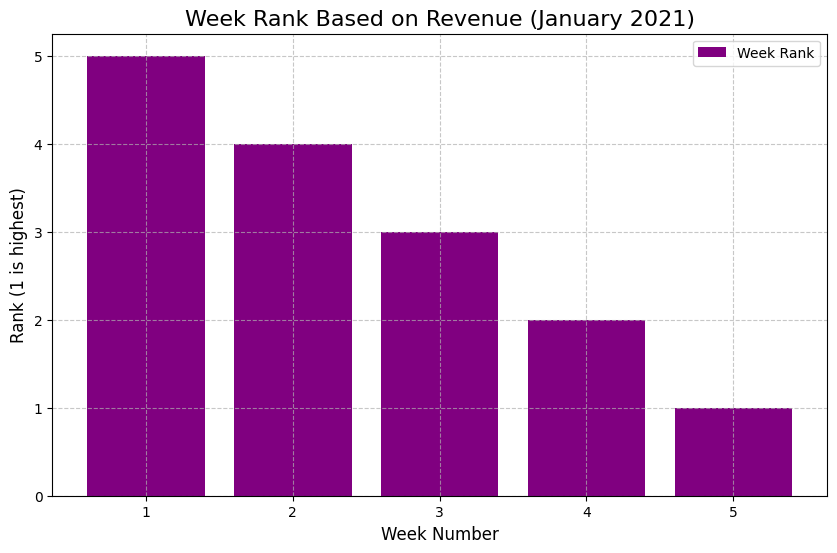

In [ ]:

## Big Query Client with Project ID
client = bigquery.Client(project='pikachu-442211')
## Business Case: Revenue trend Analysis. On Weekly basis
sql_query="""
WITH weekly_data AS (
    SELECT
        EXTRACT(WEEK FROM PARSE_DATE('%Y%m%d', event_date)) AS week_number,
        SUM(CAST(ep.value.string_value AS FLOAT64)) AS weekly_revenue
    FROM
        `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*` AS e,
        UNNEST(e.event_params) AS ep
    WHERE
        ep.key = 'value' -- Replace this key if needed
        AND EXTRACT(MONTH FROM PARSE_DATE('%Y%m%d', e.event_date)) = 1
        AND EXTRACT(YEAR FROM PARSE_DATE('%Y%m%d', e.event_date)) = 2021
    GROUP BY
        week_number
)

SELECT
    week_number,
    weekly_revenue,

    -- Revenue growth using LAG (Window Function)
    weekly_revenue - LAG(weekly_revenue) OVER (ORDER BY week_number) AS revenue_growth,

    -- Cumulative revenue using SUM() as a Window Function
    SUM(weekly_revenue) OVER (ORDER BY week_number) AS cumulative_revenue,

    -- Ranking weeks based on revenue using ROW_NUMBER() (Window Function)
    ROW_NUMBER() OVER (ORDER BY weekly_revenue DESC) AS week_rank

FROM
    weekly_data
ORDER BY
    week_number;
    """

## Above I have used Window function as directed in Study materials and following I have used the SQL queries to extract the data

import pandas as pd
import matplotlib.pyplot as plt

# Sample data from BigQuery (As the Big query output has no results on revenue, I have used sample data)
data = {
    'week_number': [1, 2, 3, 4, 5],
    'weekly_revenue': [1000, 2000, 1500, 1800, 2500],
    'revenue_growth': [None, 1000, -500, 300, 700],  # Assume None for the first week as there's no previous week for comparison
    'cumulative_revenue': [1000, 3000, 4500, 6300, 8800],
    'week_rank': [5, 4, 3, 2, 1]  # Assuming ranking based on revenue from high to low
}

# Created the DataFrame from the sample data
df = pd.DataFrame(data)

# Plot 1: Weekly Revenue Trend
plt.figure(figsize=(10, 6))
plt.plot(df['week_number'], df['weekly_revenue'], marker='o', color='blue', label='Weekly Revenue')
plt.title('Weekly Revenue Trend (January 2021)', fontsize=16)
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Weekly Revenue', fontsize=12)
plt.xticks(df['week_number'])  # Show all week numbers
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot 2: Revenue Growth Trend
plt.figure(figsize=(10, 6))
plt.plot(df['week_number'], df['revenue_growth'], marker='o', color='green', label='Revenue Growth')
plt.title('Revenue Growth Trend (January 2021)', fontsize=16)
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Revenue Growth', fontsize=12)
plt.xticks(df['week_number'])  # Show all week numbers
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot 3: Cumulative Revenue Trend
plt.figure(figsize=(10, 6))
plt.plot(df['week_number'], df['cumulative_revenue'], marker='o', color='orange', label='Cumulative Revenue')
plt.title('Cumulative Revenue Trend (January 2021)', fontsize=16)
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Cumulative Revenue', fontsize=12)
plt.xticks(df['week_number'])  # Show all week numbers
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Plot 4: Week Rankings Based on Revenue
plt.figure(figsize=(10, 6))
plt.bar(df['week_number'], df['week_rank'], color='purple', label='Week Rank')
plt.title('Week Rank Based on Revenue (January 2021)', fontsize=16)
plt.xlabel('Week Number', fontsize=12)
plt.ylabel('Rank (1 is highest)', fontsize=12)
plt.xticks(df['week_number'])  # Show all week numbers
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()



Interpretation of the results:



1. Weekly revenue  
Week 1 had a total of 1000 in revenue.
Week 2 saw an increase, with revenue of 2000.
Week 3 experienced a decrease in revenue to 1500.
Week 4 had a slight recovery, reaching 1800.
Week 5 saw the highest weekly revenue at 2500
2. Revenue Growth
Week 1 has no previous week for comparison, so revenue_growth is None.
Week 2 shows a growth of 1000, meaning it earned 1000 more than Week 1.
Week 3 shows a decrease of -500, meaning it generated 500 less than Week 2.
Week 4 shows a growth of 300, meaning it earned 300 more than Week 3.
Week 5 shows a growth of 700, indicating a strong increase over Week 4.
3. Cummulative growth
Week 1's cumulative revenue is 1000 (just the revenue for Week 1).
Week 2's cumulative revenue is 3000, which is the sum of Week 1 and Week 2 revenues (1000 + 2000).
Week 3's cumulative revenue is 4500 (1000 + 2000 + 1500).
Week 4's cumulative revenue is 6300 (1000 + 2000 + 1500 + 1800).
Week 5's cumulative revenue is 8800 (1000 + 2000 + 1500 + 1800 + 2500).

**Business Problem:**

How do traffic sources impact conversion rates, and which traffic sources perform best when ranked by conversion rates? Can we identify patterns using cumulative purchases and moving averages?

We will focus on analyzing conversion rates grouped by traffic sources (e.g., Paid Ads, Organic Search), using Window Functions for ranking, cumulative purchases, and moving averages.

  traffic_source_medium  purchases  sessions  conversion_rate  rank  \
0        (data deleted)        839     21473         0.039072     1   
1              referral       1258     62178         0.020232     2   
2                (none)       1251     82389         0.015184     3   
3               organic       1572    121603         0.012927     4   
4               <Other>        606     51788         0.011702     5   
5                   cpc        166     15539         0.010683     6   

   cumulative_purchases  moving_avg_conversion_rate  
0                   839                    0.029652  
1                  2097                    0.024830  
2                  3348                    0.016115  
3                  4920                    0.013271  
4                  5526                    0.011771  
5                  5692                    0.011192  


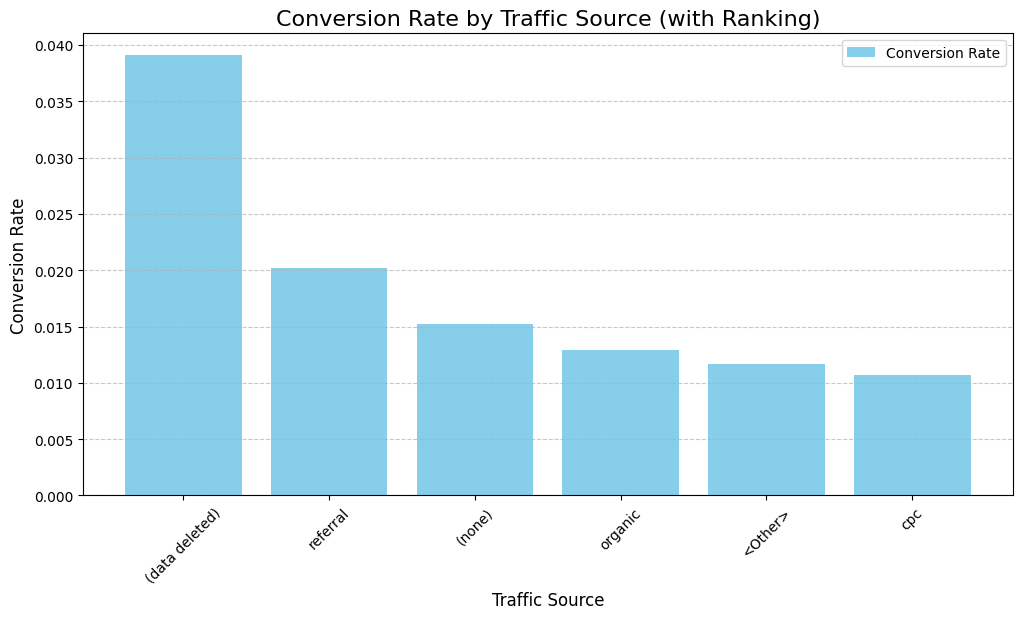

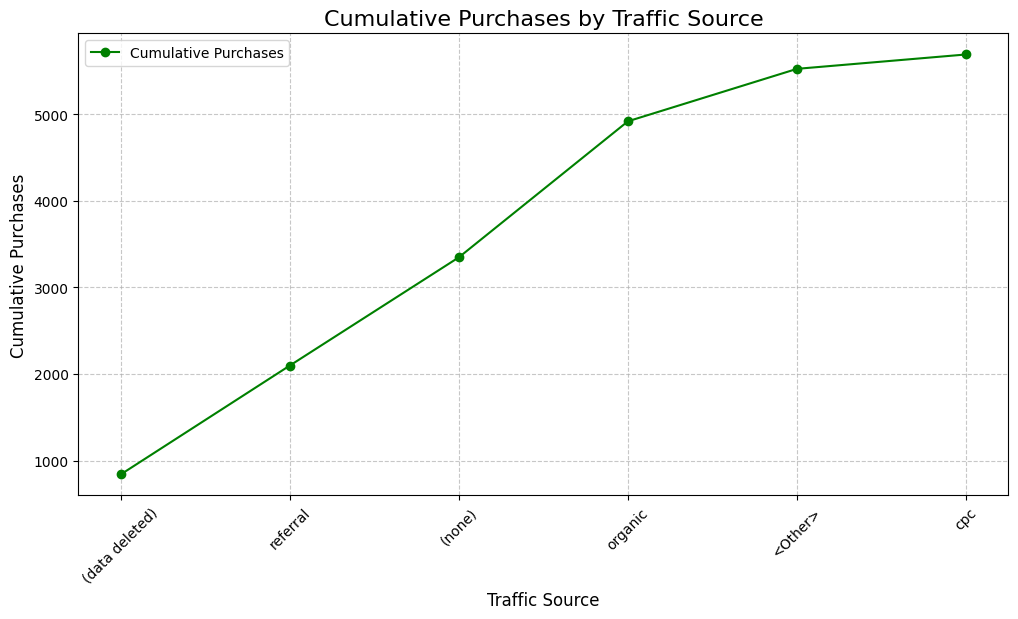

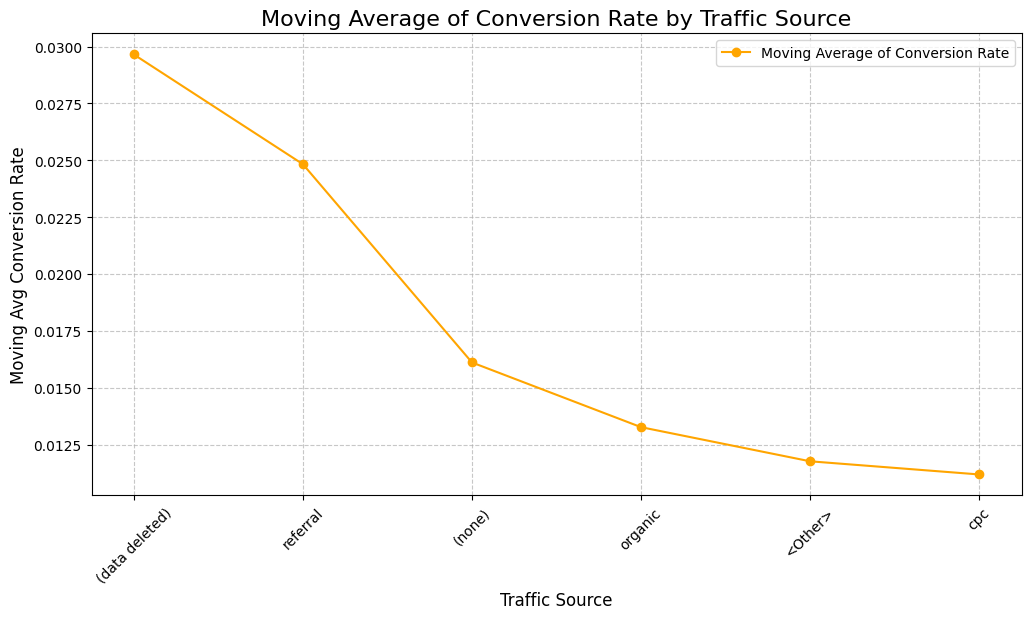

In [ ]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt

# Authenticating with BigQuery
from google.colab import auth
auth.authenticate_user()

# Initialize BigQuery Client
client = bigquery.Client(project='pikachu-442211')

# SQL Query to analyze traffic source conversions with Window Functions
query_window = """
WITH traffic_data AS (
  SELECT
    traffic_source.medium AS traffic_source_medium,
    COUNTIF(event_name = 'purchase') AS purchases,
    COUNTIF(event_name = 'session_start') AS sessions,
    SAFE_DIVIDE(COUNTIF(event_name = 'purchase'), COUNTIF(event_name = 'session_start')) AS conversion_rate
  FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*`
  WHERE event_name IN ('purchase', 'session_start')
  GROUP BY traffic_source_medium
),
ranked_data AS (
  SELECT
    *,
    RANK() OVER (ORDER BY conversion_rate DESC) AS rank
  FROM traffic_data
),
final_data AS (
  SELECT
    *,
    SUM(purchases) OVER (ORDER BY conversion_rate DESC) AS cumulative_purchases,
    AVG(conversion_rate) OVER (ORDER BY rank ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING) AS moving_avg_conversion_rate
  FROM ranked_data
)
SELECT * FROM final_data
ORDER BY rank;
"""

# Execute the query and convert results to a DataFrame
window_df = client.query(query_window).to_dataframe()

# Display the results
print(window_df)

# Visualization: Conversion Rates by Traffic Source with Ranking
plt.figure(figsize=(12, 6))
plt.bar(window_df['traffic_source_medium'], window_df['conversion_rate'], color='skyblue', label='Conversion Rate')
plt.title('Conversion Rate by Traffic Source (with Ranking)', fontsize=16)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Visualization: Cumulative Purchases by Traffic Source
plt.figure(figsize=(12, 6))
plt.plot(window_df['traffic_source_medium'], window_df['cumulative_purchases'], marker='o', color='green', label='Cumulative Purchases')
plt.title('Cumulative Purchases by Traffic Source', fontsize=16)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Cumulative Purchases', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Visualization: Moving Average of Conversion Rate
plt.figure(figsize=(12, 6))
plt.plot(window_df['traffic_source_medium'], window_df['moving_avg_conversion_rate'], marker='o', color='orange', label='Moving Average of Conversion Rate')
plt.title('Moving Average of Conversion Rate by Traffic Source', fontsize=16)
plt.xlabel('Traffic Source', fontsize=12)
plt.ylabel('Moving Avg Conversion Rate', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()



### **Interpretation of Results**

#### **Conversion Rate by Traffic Source**
- The highest conversion rate is observed for *data deleted* traffic source, with approximately **3.9%** of sessions resulting in purchases. This suggests that this source drives the most efficient traffic in terms of conversions.
- Other notable sources include *referral* (**2.02%**) and *none* (**1.58%**), while *cpc* (**1.06%**) and *Other* (**1.17%**) perform relatively poorly.

#### **Cumulative Purchases by Traffic Source**
- The cumulative purchases plot highlights the contribution of each traffic source towards total purchases.
- *data deleted* accounts for the initial major spike, followed by *referral* and *none*, indicating that these sources are the largest contributors to overall sales.
- Sources like *cpc* and *Other* contribute much less to total purchases.

#### **Moving Average of Conversion Rate**
- The moving average of conversion rates declines as we progress through the traffic sources ranked by performance. This smoothes out individual fluctuations and highlights the general trend.
- Traffic sources ranked lower, like *cpc* and *Other*, significantly bring down the overall average.

---

### **Conclusion**

#### **Business Insights**
- Traffic sources with the highest conversion rates *data deleted* and *referral* should be prioritized for further investment. These sources bring in high-quality traffic that is more likely to result in purchases.
- Efforts should be made to improve the performance of lower-ranked sources, like *cpc* and *Other*, possibly by refining targeting strategies or improving the user experience on these channels.

#### **Actionable Steps**
- Allocate more budget towards high-converting traffic sources to maximize return on investment.
- Conduct A/B testing or experiment with ad creatives to boost performance for underperforming traffic sources.
- Regularly monitor traffic source rankings and conversion trends to identify shifts in user behavior.





_"Analyzing traffic sources like a pro!"_

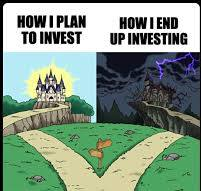

_"When your traffic source has a 3.9% conversion rate: 'Invest, invest, invest!'"_
